In [2]:
en_text = "A Dog Run back corner near spare bedrooms"

import spacy
spacy_en = spacy.load('en')
def tokenize(en_text):
    return [tok.text for tok in spacy_en.tokenizer(en_text)]
print(tokenize(en_text))

['A', 'Dog', 'Run', 'back', 'corner', 'near', 'spare', 'bedrooms']


In [3]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
print(word_tokenize(en_text))

[nltk_data] Downloading package punkt to /Users/wonjun/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['A', 'Dog', 'Run', 'back', 'corner', 'near', 'spare', 'bedrooms']


In [4]:
print(en_text.split())

['A', 'Dog', 'Run', 'back', 'corner', 'near', 'spare', 'bedrooms']


사실 영어의 경우에는 띄어쓰기 단위로 토큰화를 해도 단어들 간 구분이 꽤나 명확하기 때문에, 토큰화 작업이 수월합니다. 하지만 한국어의 경우에는 토큰화 작업이 훨씬 까다롭습니다. 그 이유는 한국어는 조사, 접사 등으로 인해 단순 띄어쓰기 단위로 나누면 같은 단어가 다른 단어로 인식되어서 단어 집합(vocabulary)의 크기가 불필요하게 커지기 때문입니다.

단어 집합(vocabuary)이란 중복을 제거한 텍스트의 총 단어의 집합(set)을 의미합니다.
예를 들어 단어 '사과'가 많이 들어간 어떤 문장에 띄어쓰기 토큰화를 한다면 '사과가', '사과를', '사과의', '사과와', '사과는'과 같은 식으로 같은 단어임에도 조사가 붙어서 다른 단어로 인식될 수 있습니다. 예를 통해 구체적으로 이해해봅시다.

# 형태소 토큰화

In [5]:
kor_text = "사과의 놀라운 효능이라는 글을 봤어. 그래서 오늘 사과를 먹으려고 했는데 사과가 썩어서 슈퍼에 가서 사과랑 오렌지 사왔어"

In [7]:
from konlpy.tag import Mecab
tokenizer = Mecab()
print(tokenizer.morphs(kor_text))

['사과', '의', '놀라운', '효능', '이', '라는', '글', '을', '봤', '어', '.', '그래서', '오늘', '사과', '를', '먹', '으려고', '했', '는데', '사과', '가', '썩', '어서', '슈퍼', '에', '가', '서', '사과', '랑', '오렌지', '사', '왔', '어']


# 단어 집합(Vocabulary) 생성

단어 집합(vocabuary)이란 중복을 제거한 텍스트의 총 단어의 집합(set)을 의미합니다. 우선, 실습을 위해서 깃허브에서 '네이버 영화 리뷰 분류하기' 데이터를 다운로드하겠습니다. 네이버 영화 리뷰 데이터는 총 20만 개의 영화 리뷰를 긍정 1, 부정 0으로 레이블링한 데이터입니다.

In [8]:
import urllib.request
import pandas as pd
from konlpy.tag import Mecab
from nltk import FreqDist
import numpy as np
import matplotlib.pyplot as plt
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")
data = pd.read_table('ratings.txt') # 데이터프레임에 저장
data[:10]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1
5,2190435,사랑을 해본사람이라면 처음부터 끝까지 웃을수 있는영화,1
6,9279041,완전 감동입니다 다시봐도 감동,1
7,7865729,개들의 전쟁2 나오나요? 나오면 1빠로 보고 싶음,1
8,7477618,굿,1
9,9250537,바보가 아니라 병 쉰 인듯,1


In [9]:
print('전체 샘플의 수 : {}'.format(len(data)))

전체 샘플의 수 : 200000


In [10]:
sample_data = data[:100] # 임의로 100개만 저장

In [11]:
sample_data['document'] = sample_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
sample_data[:10]

/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1
5,2190435,사랑을 해본사람이라면 처음부터 끝까지 웃을수 있는영화,1
6,9279041,완전 감동입니다 다시봐도 감동,1
7,7865729,개들의 전쟁 나오나요 나오면 빠로 보고 싶음,1
8,7477618,굿,1
9,9250537,바보가 아니라 병 쉰 인듯,1


In [12]:
# 불용어 정의
stopwords=['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [13]:
tokenizer = Mecab()
tokenized=[]
for sentence in sample_data['document']:
    temp = []
    temp = tokenizer.morphs(sentence) # 토큰화
    temp = [word for word in temp if not word in stopwords] # 불용어 제거
    tokenized.append(temp)
print(tokenized[:10])

[['어릴', '때', '보', '고', '지금', '다시', '봐도', '재밌', '어요', 'ㅋㅋ'], ['디자인', '을', '배우', '학생', '외국', '디자이너', '그', '일군', '전통', '을', '통해', '발전', '해', '문화', '산업', '부러웠', '는데', '사실', '우리', '나라', '에서', '그', '어려운', '시절', '끝', '까지', '열정', '을', '지킨', '노라노', '같', '전통', '있', '어', '저', '같', '사람', '꿈', '을', '꾸', '고', '이뤄나갈', '수', '있', '다는', '것', '감사', '합니다'], ['폴리스', '스토리', '시리즈', '부터', '뉴', '까지', '버릴', '께', '하나', '없', '음', '최고'], ['연기', '진짜', '개', '쩔', '구나', '지루', '할거', '라고', '생각', '했', '는데', '몰입', '해서', '봤', '다', '그래', '이런', '게', '진짜', '영화', '지'], ['안개', '자욱', '밤하늘', '떠', '있', '초승달', '같', '영화'], ['사랑', '을', '해', '본', '사람', '라면', '처음', '부터', '끝', '까지', '웃', '을', '수', '있', '영화'], ['완전', '감동', '입니다', '다시', '봐도', '감동'], ['개', '전쟁', '나오', '나요', '나오', '면', '빠', '로', '보', '고', '싶', '음'], ['굿'], ['바보', '아니', '라', '병', '쉰', '인', '듯']]


이제 단어 집합을 만들어봅시다. NLTK에서는 빈도수 계산 도구인 FreqDist()를 지원합니다.

In [14]:
vocab = FreqDist(np.hstack(tokenized))
print('단어 집합의 크기 : {}'.format(len(vocab)))

단어 집합의 크기 : 664


In [15]:
vocab['재밌']

10

'재밌'이란 단어가 총 10번 등장하였습니다. most_common()는 상위 빈도수를 가진 주어진 수의 단어만을 리턴합니다. 이를 사용하여 등장 빈도수가 높은 단어들을 원하는 개수만큼만 얻을 수 있습니다. 등장 빈도수 상위 500개의 단어만 단어 집합으로 저장해봅시다.


In [16]:
vocab_size = 500
# 상위 vocab_size개의 단어만 보존
vocab = vocab.most_common(vocab_size)
print('단어 집합의 크기 : {}'.format(len(vocab)))

단어 집합의 크기 : 500


# 각 단어에 고유한 정수 부여

enumerate()는 순서가 있는 자료형(list, set, tuple, dictionary, string)을 입력으로 받아 인덱스를 순차적으로 함께 리턴한다는 특징이 있습니다. 인덱스 0과 1은 다른 용도로 남겨두고 나머지 단어들은 2부터 501까지 순차적으로 인덱스를 부여해봅시다.

In [17]:
word_to_index = {word[0] : index + 2 for index, word in enumerate(vocab)}
word_to_index['pad'] = 1
word_to_index['unk'] = 0

이제 기존의 훈련 데이터에서 각 단어를 고유한 정수로 부여하는 작업을 진행해보겠습니다.

In [19]:
encoded = []
for line in tokenized: #입력 데이터에서 1줄씩 문장을 읽음
    temp = []
    for w in line: #각 줄에서 1개씩 글자를 읽음
        try:
            temp.append(word_to_index[w]) # 글자를 해당되는 정수로 변환
        except KeyError: # 단어 집합에 없는 단어일 경우 unk로 대체된다.
            temp.append(word_to_index['unk']) # unk의 인덱스로 변환

    encoded.append(temp)

In [20]:
print(encoded[:10])

[[79, 27, 9, 4, 50, 42, 80, 16, 28, 29], [188, 5, 81, 189, 190, 191, 43, 192, 113, 5, 193, 194, 24, 114, 195, 196, 13, 51, 82, 115, 30, 43, 197, 116, 117, 31, 198, 5, 199, 200, 17, 113, 7, 68, 52, 17, 44, 201, 5, 202, 4, 203, 14, 7, 83, 32, 204, 84], [205, 118, 206, 53, 207, 31, 208, 209, 54, 10, 25, 11], [45, 33, 119, 210, 211, 212, 213, 69, 46, 34, 13, 214, 120, 15, 2, 215, 70, 8, 33, 3, 35], [216, 217, 218, 219, 7, 220, 17, 3], [121, 5, 24, 36, 44, 122, 123, 53, 117, 31, 85, 5, 14, 7, 3], [124, 37, 221, 42, 80, 37], [119, 222, 55, 223, 55, 86, 224, 38, 9, 4, 47, 25], [56], [225, 87, 88, 226, 227, 57, 89]]


# 길이가 다른 문장들을 모두 동일한 길이로 바꿔주는 패딩(padding)

이제 길이가 다른 리뷰들을 모두 동일한 길이로 바꿔주는 패딩 작업을 진행해보겠습니다. 앞서 단어 집합에 패딩을 위한 토큰인 'pad'를 추가했었습니다. 패딩 작업은 정해준 길이로 모든 샘플들의 길이를 맞춰주되, 길이가 정해준 길이보다 짧은 샘플들에는 'pad' 토큰을 추가하여 길이를 맞춰주는 작업입니다.

리뷰의 개수 : 100 
리뷰의 최대 길이 : 62
리뷰의 최소 길이 : 1
리뷰의 평균 길이 : 13.900000


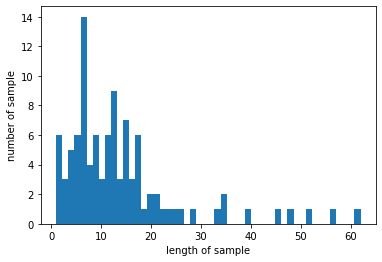

In [24]:
max_len = max(len(l) for l in encoded)
print('리뷰의 개수 : %d '% len(encoded))
print('리뷰의 최대 길이 : %d' % max_len)
print('리뷰의 최소 길이 : %d' % min(len(l) for l in encoded))
print('리뷰의 평균 길이 : %f' % (sum(map(len, encoded))/len(encoded)))
plt.hist([len(s) for s in encoded], bins=50)
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()

가장 길이가 긴 리뷰의 길이는 62입니다. 모든 리뷰의 길이를 62으로 통일시켜주겠습니다.

In [25]:
for line in encoded:
    if len(line) < max_len: # 현재 샘플이 정해준 길이보다 짧으면
        line += [word_to_index['pad']] * (max_len - len(line)) # 나머지는 전부 'pad' 토큰으로 채운다.

In [26]:
print('리뷰의 최대 길이 : %d' % max(len(l) for l in encoded))
print('리뷰의 최소 길이 : %d' % min(len(l) for l in encoded))
print('리뷰의 평균 길이 : %f' % (sum(map(len, encoded))/len(encoded)))

리뷰의 최대 길이 : 62
리뷰의 최소 길이 : 62
리뷰의 평균 길이 : 62.000000


In [27]:
print(encoded[:3])

[[79, 27, 9, 4, 50, 42, 80, 16, 28, 29, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [188, 5, 81, 189, 190, 191, 43, 192, 113, 5, 193, 194, 24, 114, 195, 196, 13, 51, 82, 115, 30, 43, 197, 116, 117, 31, 198, 5, 199, 200, 17, 113, 7, 68, 52, 17, 44, 201, 5, 202, 4, 203, 14, 7, 83, 32, 204, 84, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [205, 118, 206, 53, 207, 31, 208, 209, 54, 10, 25, 11, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


이제 단어들을 고유한 정수로 맵핑하였으니, 각 정수를 고유한 단어 벡터로 바꾸는 작업이 필요합니다. 단어 벡터를 얻는 방법은 크게 원-핫 인코딩과 워드 임베딩이 있는데, 주로 워드 임베딩이 사용됩니다. 원-핫 인코딩과 워드 임베딩에 대해서는 9챕터에서 다룹니다.

9챕터로 넘어가기 전에 우리가 배워야 할 것은 방금 했던 과정을 좀 더 쉽게 수행해주는 파이토치의 토치텍스트라는 도구입니다.